In [9]:
import pypistats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import toml_config

conf = toml_config.load("../config.toml")

In [37]:
data = []
for package in conf.packages:
    pkg_df = (
        pypistats.overall(package, total=True, format="pandas")
        .groupby("category")
        .get_group("with_mirrors")
        .sort_values("date")
    )
    pkg_df.drop(["percent", "category"], axis=1, inplace=True)
    pkg_df.to_csv(f'../data/{package}.csv', index=False)

In [38]:
for package in conf.packages:
	data.append(pd.read_csv(f'../data/{package}.csv', index_col=False))

In [39]:
df = data[0]

In [40]:
df.dtypes

date         object
downloads     int64
dtype: object

In [41]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
downloads,181.0,314697.066298,98556.116628,132563.0,213771.0,329730.0,398889.0,463319.0


In [42]:
df.head()

,date,downloads
0,2022-07-14,304318
1,2022-07-15,281769
2,2022-07-16,151295
3,2022-07-17,132563
4,2022-07-18,296557


In [43]:
df.head()

,date,downloads
0,2022-07-14,304318
1,2022-07-15,281769
2,2022-07-16,151295
3,2022-07-17,132563
4,2022-07-18,296557


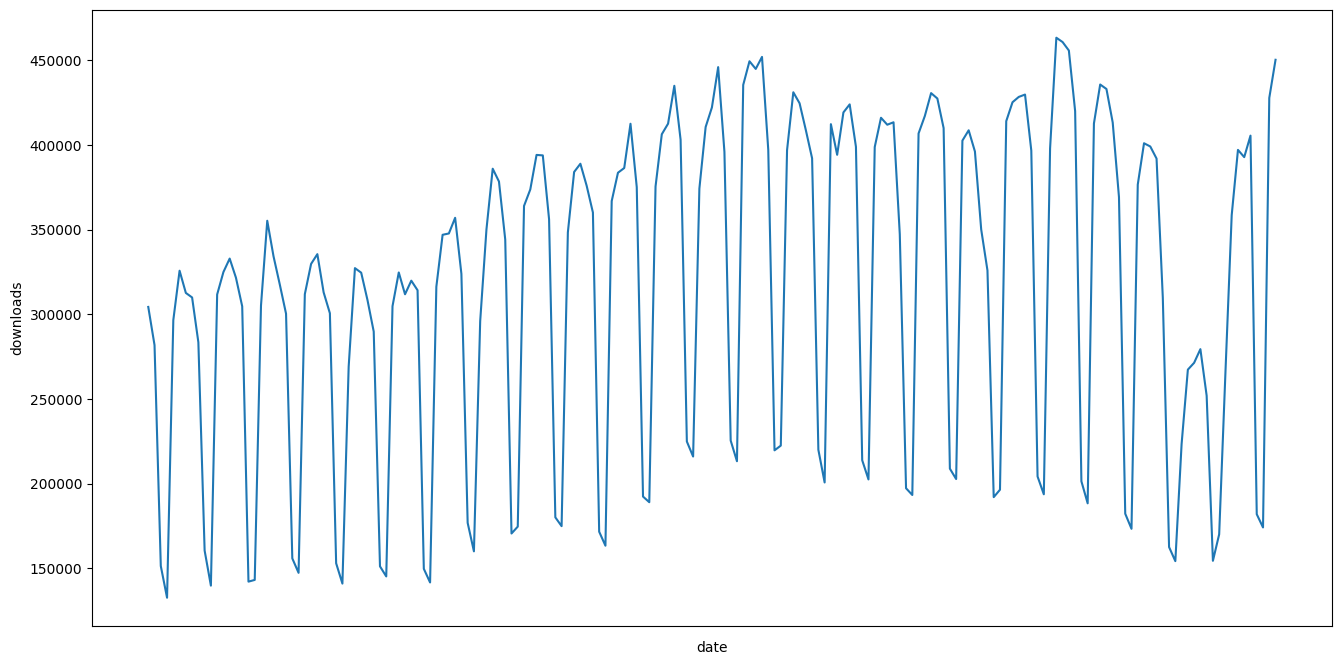

In [44]:
fig, ax = plt.subplots(figsize=(16, 8))
# won't be able to display time clearly
ax.tick_params(bottom=False)  # remove the ticks
ax.set(xticklabels=[])  # remove the tick labels

plot = sns.lineplot(x="date", y="downloads", estimator=None, data=df)

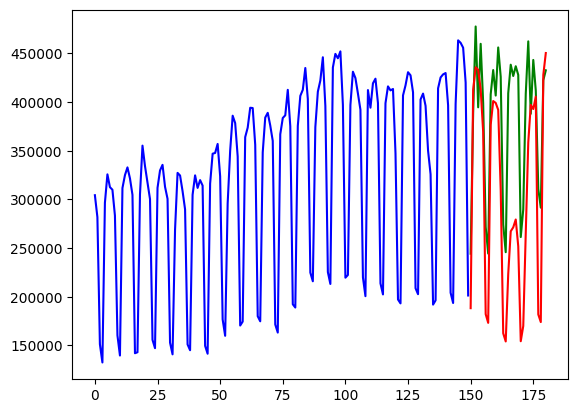

In [45]:
from pmdarima.model_selection import train_test_split
import pmdarima as pm

y = df["downloads"]
train, test = train_test_split(y, train_size=150)
model = pm.auto_arima(train, seasonal=True, m=3)

forecasts = model.predict(test.shape[0])
x = np.arange(y.shape[0])
# train
plt.plot(x[:150], train, c="blue")
# forecast
plt.plot(x[150:], forecasts, c="green")
# actuals
plt.plot(x[150:], y[150:], c="red")
plt.show()

In [46]:
import numpy as np
import plotly.express as px
import pandas as pd

forecasts = model.predict(test.shape[0])
df["date"] = pd.to_datetime(df["date"], infer_datetime_format=True)


fig = px.line(df[:150], x=df["date"][:150], y="downloads", title="Forecast")
fig.add_scatter(x=df["date"][150:], y=forecasts, mode="lines", name="Forecast", line=dict(width=2, color="green"))
fig.show()

In [50]:
recent_date = df['date'].max()

In [53]:
forecasts = model.predict(conf.forecast_days)
df["date"] = pd.to_datetime(df["date"], infer_datetime_format=True)

forecast_duration = pd.date_range(recent_date, periods=conf.forecast_days, freq='D')
fig = px.line(df, x=df["date"], y="downloads", title="Forecast")
fig.add_scatter(x=forecast_duration, y=forecasts, mode="lines", name="Forecast", line=dict(width=2, color="green"))
fig.show()